In [1]:
from pathlib import Path
import sys
sys.path.append(str(Path().resolve().parent))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lib.genetic_data_helpers import *
from lib.data_access_helpers import load_fasta_records
from lib.aminoacids import AA_1_TO_3, AA_3_TO_1
from lib.calculations import count_amino_acids

In [2]:
path = '../data/dependent_hydrophobic_genes.csv'
srp_dep = pd.read_csv(path)

print(f"SRP dependent shape: {srp_dep.shape}")

path = "../data/dep_proteins_filtered.fasta"
srp_dep_records = load_fasta_records(path)
print(f"Number of records: {len(srp_dep_records)}")

SRP dependent shape: (344, 6)
Number of records: 344


In [3]:
window_size = 21
distance = 35

window_counts = dict.fromkeys(AA_1_TO_3.keys(), 0)
complement_counts = dict.fromkeys(AA_1_TO_3.keys(), 0)

for record in srp_dep_records:
    gene = record.id
    row = srp_dep[srp_dep['gene'] == gene]
    # get the coordinate of the first hydrophobic region's end (in amino acids)
    hydro_end_aa = int(row['first_hydrophobic_end'].iloc[0])
    
    extraction = extract_window_and_complement(record, window_size, distance, hydro_end_aa)
    
    if extraction is None:
        continue
    else:
        window, complement = extraction
        
    window_counts = count_amino_acids(window_counts, window)
    complement_counts = count_amino_acids(complement_counts, complement)
          

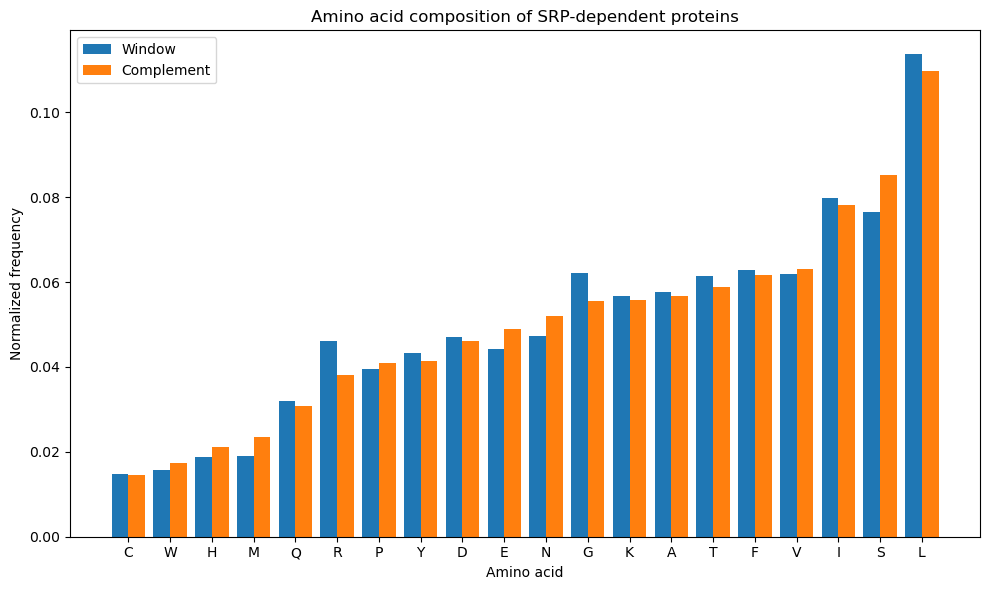

In [4]:

# Ensure both dictionaries have the same set of amino acids
amino_acids = sorted(set(window_counts.keys()) | set(complement_counts.keys()))

# Normalize counts to frequencies
total_window = sum(window_counts.values())
total_complement = sum(complement_counts.values())

freq_window = [window_counts.get(aa, 0) / total_window for aa in amino_acids]
freq_complement = [complement_counts.get(aa, 0) / total_complement for aa in amino_acids]

# Sort amino acids by complement_counts frequency
sorted_indices = np.argsort(freq_complement)

amino_acids_sorted = [amino_acids[i] for i in sorted_indices]
freq_window_sorted = [freq_window[i] for i in sorted_indices]
freq_complement_sorted = [freq_complement[i] for i in sorted_indices]

# Bar plot setup
x = np.arange(len(amino_acids_sorted))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, freq_window_sorted, width, label="Window")
ax.bar(x + width/2, freq_complement_sorted, width, label="Complement")

# Labels and style
ax.set_xticks(x)
ax.set_xticklabels(amino_acids_sorted)
ax.set_ylabel("Normalized frequency")
ax.set_xlabel("Amino acid")
ax.set_title("Amino acid composition of SRP-dependent proteins")
ax.legend()

plt.tight_layout()
plt.show()
